In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import transforms
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.text as mtext

from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from shapely.geometry import Polygon
from scipy import ndimage

%matplotlib notebook

def multi2single(gpdf):
    gpdf_singlepoly = gpdf[gpdf.geometry.type == 'Polygon']
    gpdf_multipoly = gpdf[gpdf.geometry.type == 'MultiPolygon']

    for i, row in gpdf_multipoly.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gpd.GeoDataFrame(row, crs=gpdf_multipoly.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singlepoly = pd.concat([gpdf_singlepoly, df])

    gpdf_singlepoly.reset_index(inplace=True, drop=True)
    return gpdf_singlepoly

def Scale_Arrow(Units,offset):
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=1)
    t = ax0.text(xl[1]-offset*2,yl[0]+offset*2, "   ", ha="center", va="center", rotation=90+rotation,
                size=10,
                bbox=bbox_props)
    t = ax0.text(xl[1]-offset*2,yl[0]+offset*2, "N", ha="center", va="center", rotation=rotation,
                size=10)


    ax0.add_patch(Rectangle((xl[0]+offset,yl[0]+offset),Units,25,
                       edgecolor='black',facecolor='white',lw=1))
    ax0.text(xl[0]+Units+offset+offset,yl[0]+offset,
        str(Units)+' m',fontsize=10,rotation=0)
    
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0,  orig_handle, **self.text_props)
        handlebox.add_artist(title)

## Map Paramters

In [11]:
Size = (6.5,7)
Scale = 435
Center = [516250,7708050]
X2,Y2,X2s,Y2s = 0.01,0.01,0.98,0.98
X0,Y0,X0s,Y0s = 0.015, 0.425, 0.97, 0.5
X1,Y1,X1s,Y1s = 0.015, 0.015, 0.5, 0.4

# X2,Y2,X2s,Y2s = 0.01,0.01,0.98,0.98
# X0,Y0,X0s,Y0s = 0.015, 0.01, 0.96, 0.565#0.425, 0.96, 0.565
# X1,Y1,X1s = 0.01, 0.01, 0.5

xScale = Scale
yScale = Scale * Y0s/X0s * Size[1]/Size[0]
# print(yScale/xScale*X1s)
# Y1s = yScale/xScale*X1s
xl = Center[0]-xScale,Center[0]+xScale
yl = Center[1]-yScale,Center[1]+yScale

Colors = {
'Shrub':[1,.5,.25],
'Sedge':[0.1,1,0.75],
'Fen':[0.1,1,0.75],
'Grass':[.6,1,0.3],
'Sparse':[.85,.85,.85],
'Upland':[.85,.85,.75],
'Water':[0.5,0.5,1],
'Ocean':[0.5,0.5,1]
}

rotation = -22
polygon = Polygon([[xl[0], yl[0]], [xl[1], yl[0]], [xl[1], yl[1]], [xl[0], yl[1]]])
Box = gpd.GeoDataFrame(index=[0],data={'geometry':polygon})
Box.geometry = Box.geometry.rotate(-rotation,origin = Center)

Veg = 'C:/Illisarvik/Mapping/Vegetation_Skeeter_2.5.shp'
Clim = 'C:/Illisarvik/Footprints/Contours/Climatology.shp'
Chambers = "C:/Illisarvik/Mapping/Basin_Points.shp"
img = mpimg.imread("C://Illisarvik//Photos//DronePhotos//Oblique//DJI_0123.JPG")
Y1s = (img.shape[0]/img.shape[1]*X1s)*Size[0]/Size[1]

Clim = gpd.read_file(Clim)
Veg = gpd.read_file(Veg)
Chambers = gpd.read_file(Chambers)
Veg.loc[Veg['Id']=='0','DKey']='1'
Basin = Veg.dissolve(by='DKey').buffer(.01) ## Buffer to get rid of overlap slivers
Basin = gpd.GeoDataFrame(data={'geometry':Basin.geometry})

Veg = Veg.sort_values('Unit')
Veg.reset_index(inplace=True)
Veg = gpd.overlay(Veg, Box, how='intersection')
Veg = Veg.dissolve(by='index')
Veg = multi2single(Veg)

Veg['coords'] = Veg['geometry'].apply(lambda x: x.representative_point().coords[:])
Veg['coords'] = [coords[0] for coords in Veg['coords']]

Labels = gpd.GeoDataFrame(Veg['geometry'].apply(lambda x: x.representative_point()))
Labels['FullUnit'] = Veg['FullUnit']

Veg.geometry = Veg.geometry.rotate(rotation,origin = Center)
Chambers.geometry = Chambers.geometry.rotate(rotation,origin = Center)
Basin.geometry = Basin.geometry.rotate(rotation,origin = Center)
Clim.geometry = Clim.geometry.rotate(rotation,origin = Center)
Labels.geometry = Labels.geometry.rotate(rotation,origin = Center)
Labels['coords'] = Labels['geometry'].apply(lambda x: x.coords[:])
Labels['coords'] = [coords[0] for coords in Labels['coords']]

<IPython.core.display.Javascript object>


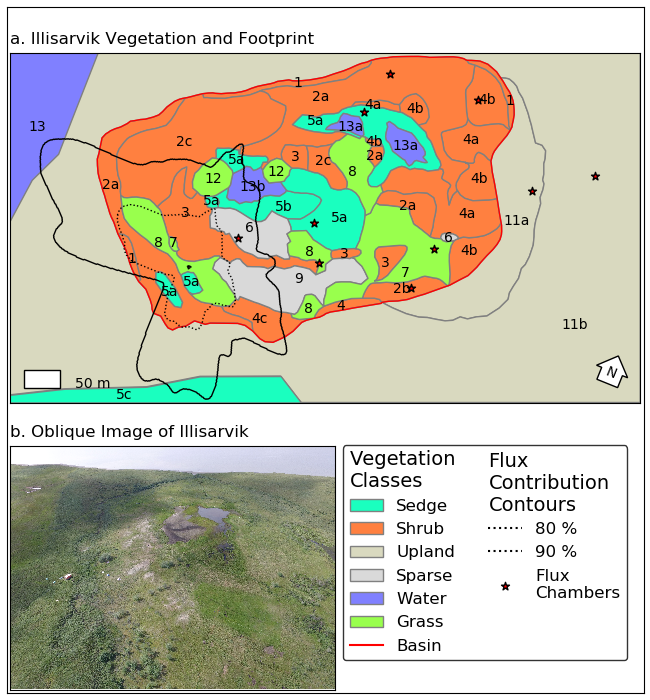

[0.015, 0.015, 0.5, 0.3482142857142857]


In [12]:
fig = plt.figure(figsize = Size)
ax = fig.add_axes([X2,Y2,X2s,Y2s])
ax0 = fig.add_axes([X0,Y0,X0s,Y0s])
# X1s = img.shape[1]/img.shape[0]*Y1s
print([X1,Y1,X1s,Y1s])
ax1 = fig.add_axes([X1,Y1,X1s,Y1s])

ax0.set_xlim(xl)
ax0.set_ylim(yl)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

Patches = []
Text = []

Classes = 'Vegetation\nClasses'
Flux = 'Flux\nContribution\nContours'
Patches.append('')
Text.append('')
Patches.append(Classes)
Text.append('')
for cl in Veg['Class'].unique():
    Veg.loc[Veg['Class'] == cl].plot(
                        facecolor = Colors[cl],
                        edgecolor = [.5,.5,.5],
                        ax = ax0,
                        label=cl,             
    )
    if cl != "Fen" and cl != "Ocean": 
        Patches.append(mpatches.Patch(facecolor=Colors[cl],edgecolor=[.5,.5,.5], label=cl))
        Text.append(cl)

for idx, row in Labels.iterrows():
    ax0.annotate(s=row['FullUnit'], xy=row['coords'],
                 horizontalalignment='center',verticalalignment='center')

Basin.plot(facecolor = 'None',edgecolor = 'red',ax = ax0,label='Basin')
L1 = mlines.Line2D([], [], color='red', label='Basin')

X = Chambers.loc[Chambers['Type']=='Chamber'].geometry.x
Y = Chambers.loc[Chambers['Type']=='Chamber'].geometry.y
L2 = ax0.scatter(X,Y,marker='*',facecolor = 'red',edgecolor='black',label='Chambers')

prms = {'facecolor':'None','edgecolor':'black'}
Clim.loc[Clim['contour'] == 0.8].plot(linestyle = ':',
                                      ax=ax0,
                                      label='% Contour',
                                     **prms)
L3 = mlines.Line2D([], [], color='black', linestyle=':', label='80 % Contour')
Clim.loc[Clim['contour'] == 0.9].plot(ax=ax0,
                                     label='% Contour',
                                     **prms)
L4 = mlines.Line2D([], [], color='black', linestyle=':', label='90 % Contour')

ax1.imshow(img)

for p,l in zip([L1,'','',Flux,L3,L4,L2,'',''],
               ['Basin','','','','80 %','90 %','Flux\nChambers','','']):
    Patches.append(p)
    Text.append(l)
    
ax.legend(Patches,
          Text,
          fontsize=12,
          loc='upper left',
          bbox_to_anchor=(X1+X1s,Y1+Y1s+.01,0,0),
          ncol=2,
          edgecolor='black',
          handler_map={Classes: LegendTitle({'fontsize': 14}),
                       '': LegendTitle({'fontsize': 14}),
                       Flux: LegendTitle({'fontsize': 14})},
         )
Scale_Arrow(50,20)

ax0.set_title('a. Illisarvik Vegetation and Footprint',loc='left')
ax1.set_title('b. Oblique Image of Illisarvik',loc='left')
plt.savefig('Fig1.png')

In [6]:
for klass in Veg['Class'].unique():
    print(klass)
    print(Veg.loc[Veg['Class']==klass].geometry.area.sum()/Basin.geometry.area.values[0])
    print()

Sedge
0.12514268577673673

Shrub
0.599524619614659

Upland
1.2763148754601943

Sparse
0.08514438609236921

Ocean
0.07715575443626499

Fen
0.04686662218956815

Water
0.03136871305811912

Grass
0.15870928105098725



In [8]:
print(Veg['Class'])

0      Sedge
1      Shrub
2      Shrub
3     Upland
4     Sparse
5      Ocean
6      Shrub
7        Fen
8      Water
9     Upland
10     Shrub
11     Shrub
12     Shrub
13     Shrub
14     Shrub
15     Grass
16     Grass
17    Sparse
18    Sparse
19     Water
20     Water
21     Sedge
22     Sedge
23     Sedge
24     Sedge
25     Sedge
26     Sedge
27     Shrub
28     Shrub
29     Shrub
30     Shrub
31     Shrub
32     Shrub
33     Shrub
34     Shrub
35     Shrub
36     Shrub
37     Shrub
38     Shrub
39     Shrub
40     Shrub
41     Grass
42     Grass
43     Shrub
44     Shrub
45     Grass
46     Grass
47     Grass
48     Grass
Name: Class, dtype: object
